# Ayudantía 2

En esta ayudantía veremos los siguientes tópicos:
- Conceptos de objeto
- Ejemplos de Pipeline, Scalers y Cross-validation
- uso de pandas
- metricas de evaluación

## Demostración de clases

Here I demonstrate several key features of classes and object-oriented programming in Python.  These include the following
- class inheritance
- overriding magic methods
- property setters and getters (using `@property` and `@<attribute>.setter` decorators)
- composition

These examples were inspired by the simple straight-forward book ["Object-Oriented Programming in Python"](http://python-textbok.readthedocs.io/en/stable/index.html) written for a MSc-level 
course in IT at the University of Cape Town.  The copyright of the book is held by University of Cape Town and individual contributors and has been released under the CC BY-SA 4.0 licence. Revision 8e685e710775+. 

Note that I will add more description as time permits.

In [1]:
import datetime
import time

I will start by defining a Person class.

In [4]:
class Person(object):
    
    def __init__(self, name, surname, gender, birthdate, **kwargs):
        self.name = name
        self.surname = surname
        self.birthdate = birthdate
        if 'male' == gender.lower() or 'boy' == gender.lower():
            self.gender = 'male'
        else:
            self.gender = 'female'
        # accomodate other input information
        for key, val in kwargs.items():
            self.__dict__[key] = val

    @property
    def fullname(self):
        return '{} {}'.format(self.name, self.surname)

    @property
    def age(self):
        today = datetime.date.today()
        age = today.year - self.birthdate.year

        if today < datetime.date(today.year, self.birthdate.month, self.birthdate.day):
            age -= 1
        return age

    # override some magic methods

    def __str__(self):
        critical_keys = ['name', 'surname', 'gender', 'birthdate', 'fullname']
        about = '\n{} is a {}-y-o {}.\n'.format(self.fullname, self.age,
                                                self.gender)
        additional_keys = list(set(self.__dict__.keys()) - set(critical_keys))
        if len(additional_keys) > 0:
            about += '--Additional info--\n'
            for key in additional_keys:
                about += '{}: {}\n'.format(key, self.__dict__[key])
        return about

    # setup comparison based on name alphabatization
    def __eq__(self, other): # does self == other?
        return self.name == other.name and self.surname == other.surname

    def __gt__(self, other): # is self > other?
        if self.surname == other.surname:
            return self.name > other.name
        return self.surname > other.surname

    # now we can define all the other methods in terms of the first two
    def __ne__(self, other): # does self != other?
        return not self == other # this calls self.__eq__(other)

    def __le__(self, other): # is self <= other?
        return not self > other # this calls self.__gt__(other)

    def __lt__(self, other): # is self < other?
        return not (self > other or self == other)

    def __ge__(self, other): # is self >= other?
        return not self < other

This expects certain critical input values when intantiating a person, their first and last name, gender, and birthdate.

In [5]:
dawn = Person('Dawn', 'Joe', 'female', datetime.date(1984, 1, 13))
print(dawn)


Dawn Joe is a 35-y-o female.



For demonstration purposes, I set this up to accept additional keyword arguments as well. This should be done with care as relying on these additional attributes can lead to problems if they are not populated.

In [6]:
jon = Person('Jon', 'Doe', 'male', datetime.date(1983, 8, 21),
             email='jon.doe@email.com', address='123 Redwood Ct',
             cell='249.298.6690', hair='red')
print(jon)


Jon Doe is a 35-y-o male.
--Additional info--
cell: 249.298.6690
address: 123 Redwood Ct
hair: red
email: jon.doe@email.com



Now lets define a Child class. It will inherit from the Person class, with one added property, nap_time.

In [8]:
class Child(Person):
    
    @property
    def nap_time(self):
        if self.age < 1:
            return [9, 1]
        elif self.age < 5:
            return [1]
        else:
            return []

    def __str__(self):
        critical_keys = ['name', 'surname', 'gender', 'birthdate', 'fullname']
        about = '{} is a {}-y-o {},\n'.format(self.fullname, self.age,
                                                self.gender)
        if len(self.nap_time) > 1:
            about += 'and takes naps at {} and {} o-clock.\n'.format(*self.nap_time)
        elif len(self.nap_time) > 0:
            about += 'with a nap time at {} o-clock.\n'.format(*self.nap_time)
        else:
            about += 'and is too old for naps.\n'

        additional_keys = list(set(self.__dict__.keys()) - set(critical_keys))
        if len(additional_keys) > 0:
            about += '--Additional info--\n'
            for key in additional_keys:
                about += '{}: {}\n'.format(key, self.__dict__[key])
        return about

In [9]:
sussy = Child('Sussy', 'Doe', 'female', datetime.date(2011, 7, 22))
print(sussy)

Sussy Doe is a 7-y-o female,
and is too old for naps.



In [10]:
johnny = Child('Johnny', 'Doe', 'male', datetime.date(2015, 3, 1),
               blankie='blue', hair='red', toy='green ball')
print(johnny)

Johnny Doe is a 4-y-o male,
with a nap time at 1 o-clock.
--Additional info--
hair: red
blankie: blue
toy: green ball



I have already been using composition, by providing a datetime object for the birthdate input value but I will go one step further. Now I will define a basic family class.

In [11]:
class Family(object):

    def __init__(self, mommy, daddy, *kids):
        self.mommy = mommy
        self.daddy = daddy
        self.kids = list(kids)
        self.number_of_kids = len(self.kids)

    def __str__(self):
        about = ('\nThe {} family is made up of {}, {}, \n'
                 'and their {} kids: \n'.format(self.daddy.surname,
                                                self.daddy.name,
                                                self.mommy.name,
                                                self.number_of_kids))
        for kid in self.kids:
            about += '{name}\n'.format(name=kid.name)

        return about

I will use this to define a family from the four people I have already instantiated, Jon, Dawn, Sussy, and Johnny.

In [12]:
simple_family = Family(dawn, jon, johnny, sussy)
print(simple_family)


The Doe family is made up of Jon, Dawn, 
and their 2 kids: 
Johnny
Sussy



Now I will define a family that can add grow using the add_child method. I will implement this two different ways to illustrate the difference between lazy and eager calculations.

In [13]:
class LazyFamily(Family):

    def __init__(self, mommy, daddy, *kids):
        self.mommy = mommy
        self.daddy = daddy
        self.kids = list(kids)

    @property
    def family_size(self):
        time.sleep(0.01)  # mimic a long calculation
        return 2 + self.number_of_kids

    @property
    def number_of_kids(self):
        time.sleep(0.01)  # mimic a long calculation
        return len(self.kids)

    def add_child(self, child):
        self.kids.append(child)

In [14]:
alicia = Child('Alicia', 'Doe', 'female', datetime.date(2017, 7, 20))
family_1 = LazyFamily(dawn, jon, johnny, sussy)
print('before: {}'.format(family_1))

family_1.add_child(alicia)
print('after: {}'.format(family_1))

before: 
The Doe family is made up of Jon, Dawn, 
and their 2 kids: 
Johnny
Sussy

after: 
The Doe family is made up of Jon, Dawn, 
and their 3 kids: 
Johnny
Sussy
Alicia



In [15]:
class EagerFamily(Family):

    def __init__(self, mommy, daddy, *kids):
        self.mommy = mommy
        self.daddy = daddy
        self.kids = list(kids)
        self._number_of_kids = len(self.kids)
        self._family_size = 2 + self.number_of_kids

    @property
    def number_of_kids(self):
        return self._number_of_kids
    @number_of_kids.setter
    def number_of_kids(self, val):
        time.sleep(0.01)  # mimic a long calculation
        self._number_of_kids = val

    @property
    def family_size(self):
        return self._family_size
    @family_size.setter
    def family_size(self, val):
        time.sleep(0.01)  # mimic a long calculation
        self._family_size = val

    def add_child(self, child):
        self.kids.append(child)
        self._number_of_kids = len(self.kids)
        self._family_size = 2 + self.number_of_kids

In [16]:
family_2 = EagerFamily(dawn, jon, johnny, sussy)
print('before: {}'.format(family_2))

rosy = Child('Rosy', 'Doe', 'female', datetime.date(2017, 1, 19))
family_2.add_child(rosy)
print('after: {}'.format(family_2))

before: 
The Doe family is made up of Jon, Dawn, 
and their 2 kids: 
Johnny
Sussy

after: 
The Doe family is made up of Jon, Dawn, 
and their 3 kids: 
Johnny
Sussy
Rosy



On the surface, these two different Family definitions seems to perform the same function. They differ in how they are calculating some of the properties, particularly family_size and number_of_kids. In the LazyFamily, nothing is calculated until it is asked for. In the EagerFamily, the calculations are performed as soon the information is available then cached or stored until needed. In this example, the operations are fairly minimal, so I added a 10 ms sleep before the calculation in both family definitions. This provides a clear comparison between the timing results of the two different approaches.
Here I query the family_size five times. In the lazy case, this means the computation to get the family_size must be performed five times instead of just once.

In [17]:
n = 5

t0 = time.time()
for i in range(n):
    lazy_family_size = family_1.family_size
t_lazy = time.time() - t0

t0 = time.time()
for i in range(n):
    eager_family_size = family_2.family_size
t_eager = time.time() - t0

print("lazy family: {}s".format(t_lazy))
print("eager family: {}s".format(t_eager))
x_faster = t_lazy / t_eager
print("eager family was {}x faster than the lazy family".format(x_faster))

lazy family: 0.1106710433959961s
eager family: 8.106231689453125e-05s
eager family was 1365.2588235294118x faster than the lazy family


Notice how large of a difference this was!

Or I can just use the %timeit magic function.

In [18]:
%timeit family_1.family_size

22.4 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit family_2.family_size

169 ns ± 3.49 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Note how this confirms that for the eager case, the value only had to be computed once.

## Cross-validation example

This is a tutorial on how to compare machine learning methods with the python library scikit-learn. We'll be using the Indian Liver Disease dataset (found [here](https://www.kaggle.com/uciml/indian-liver-patient-records)).

From the dataset page:

"This data set contains 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. The "Dataset" column is a class label used to divide groups into liver patient (liver disease) or not (no disease). This data set contains 441 male patient records and 142 female patient records."

I've used [Jason Brownlee's article](https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/) from 2016 as the basis for this article...I wanted to expand a bit on what he did as well as use a different dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
data = pd.read_csv('data/indian_liver_patient.csv') #read in the data

In [3]:
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


We'll use all columns except Gender for this tutorial. We could use gender by converting the gender to a numeric value (e.g., 0 for Male, 1 for Female) but for the purproses of this post, we'll just skip this column.

In [4]:
data_to_use = data
del data_to_use['Gender']
data_to_use.dropna(inplace=True)

In [5]:
data_to_use.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1


The 'Dataset' column is the value we are trying to predict...whether the user has liver disease or not so we'll that as our "Y" and the other columns for our "X" array.

In [6]:
values = data_to_use.values

Y = values[:,9]
X = values[:,0:9]

Before we run our machine learning models, we need to set a random number to use to seed them. This can be any random number that you'd like it to be. Some people like to use a random number generator but for the purposes of this, I'll just set it to 12 (it could just as easily be 1 or 3 or 1023 or any other number).

In [7]:
random_seed = 12

We are going to use a k-fold validation to evaluate each algorithm and will run through each model with a for loop, running the analysis and then storing the outcomes into the lists we created above. We'll use a 10-fold cross validation.

In [8]:
outcome = []
model_names = []
models = [('LogReg', LogisticRegression()), 
          ('SVM', SVC()), 
          ('DecTree', DecisionTreeClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LinDisc', LinearDiscriminantAnalysis()),
          ('GaussianNB', GaussianNB())]

We are going to use a k-fold validation to evaluate each algorithm and will run through each model with a for loop, running the analysis and then storing the outcomes into the lists we created above. We'll use a 10-fold cross validation.

In [10]:
for model_name, model in models:
    k_fold_validation = model_selection.KFold(n_splits=10, random_state=random_seed)
    results = model_selection.cross_val_score(model, X, Y, cv=k_fold_validation, scoring='accuracy')
    outcome.append(results)
    model_names.append(model_name)
    output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
    print(output_message)

LogReg| Mean=0.716909 STD=0.058303
SVM| Mean=0.715124 STD=0.058962
DecTree| Mean=0.634059 STD=0.104608
KNN| Mean=0.651301 STD=0.079872
LinDisc| Mean=0.716878 STD=0.050734
GaussianNB| Mean=0.554719 STD=0.081961


From the above, it looks like the Logistic Regression, Support Vector Machine and Linear Discrimation Analysis methods are providing the best results. If we take a look at a box plot to see what the accuracy is for each cross validation fold, we can see just how good each does relative to each other and their means.

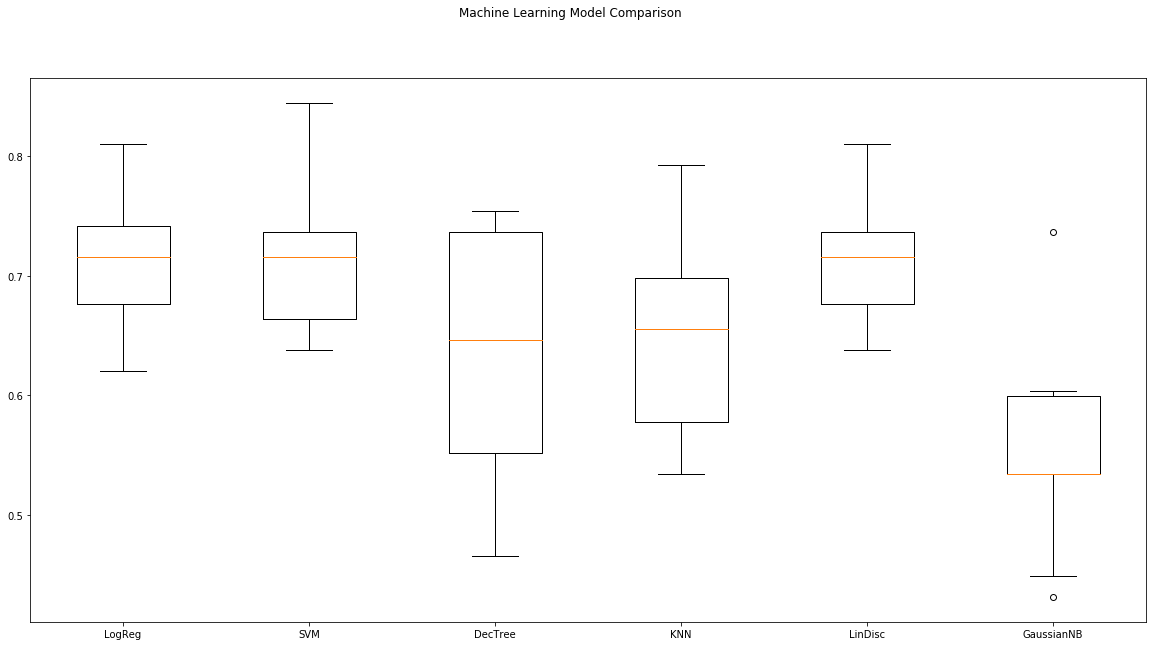

In [11]:
fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show()

another more complex example (and better) [found here](https://www.kaggle.com/aldemuro/comparing-ml-algorithms-train-accuracy-90)

## Pandas

At the very basic level, Pandas objects can be thought of as enhanced versions of NumPy structured arrays in which the rows and columns are identified with labels rather than simple integer indices.
As we will see during the course of this chapter, Pandas provides a host of useful tools, methods, and functionality on top of the basic data structures, but nearly everything that follows will require an understanding of what these structures are.
Thus, before we go any further, let's introduce these three fundamental Pandas data structures: the ``Series``, ``DataFrame``, and ``Index``.

We will start our code sessions with the standard NumPy and Pandas imports:

In [1]:
import numpy as np
import pandas as pd

## The Pandas Series Object

A Pandas ``Series`` is a one-dimensional array of indexed data.
It can be created from a list or array as follows:

In [2]:
data = pd.Series([0.25, 0.5, 0.75, 1.0])
data

0    0.25
1    0.50
2    0.75
3    1.00
dtype: float64

As we see in the output, the Series wraps both a sequence of values and a sequence of indices, which we can access with the values and index attributes. The values are simply a familiar NumPy array:

In [3]:
data.values

array([0.25, 0.5 , 0.75, 1.  ])

The ``index`` is an array-like object of type ``pd.Index``, which we'll discuss in more detail momentarily.

In [4]:
data.index

RangeIndex(start=0, stop=4, step=1)

Like with a NumPy array, data can be accessed by the associated index via the familiar Python square-bracket notation:

In [5]:
data[1]

0.5

In [6]:
data[1:3]

1    0.50
2    0.75
dtype: float64

As we will see, though, the Pandas ``Series`` is much more general and flexible than the one-dimensional NumPy array that it emulates.

### ``Series`` as generalized NumPy array

From what we've seen so far, it may look like the ``Series`` object is basically interchangeable with a one-dimensional NumPy array.
The essential difference is the presence of the index: while the Numpy Array has an *implicitly defined* integer index used to access the values, the Pandas ``Series`` has an *explicitly defined* index associated with the values.

This explicit index definition gives the ``Series`` object additional capabilities. For example, the index need not be an integer, but can consist of values of any desired type.
For example, if we wish, we can use strings as an index:

In [8]:
data = pd.Series([0.25, 0.5, 0.75, 1.0],
                 index=['a', 'b', 'c', 'd'])
data

a    0.25
b    0.50
c    0.75
d    1.00
dtype: float64

And the item access works as expected:

In [9]:
data['b']

0.5

We can even use non-contiguous or non-sequential indices:

In [10]:
data = pd.Series([0.25, 0.5, 0.75, 1.0],
                 index=[2, 5, 3, 7])
data

2    0.25
5    0.50
3    0.75
7    1.00
dtype: float64

In [11]:
data[5]

0.5

### Series as specialized dictionary

In this way, you can think of a Pandas ``Series`` a bit like a specialization of a Python dictionary.
A dictionary is a structure that maps arbitrary keys to a set of arbitrary values, and a ``Series`` is a structure which maps typed keys to a set of typed values.
This typing is important: just as the type-specific compiled code behind a NumPy array makes it more efficient than a Python list for certain operations, the type information of a Pandas ``Series`` makes it much more efficient than Python dictionaries for certain operations.

The ``Series``-as-dictionary analogy can be made even more clear by constructing a ``Series`` object directly from a Python dictionary:

In [12]:
population_dict = {'California': 38332521,
                   'Texas': 26448193,
                   'New York': 19651127,
                   'Florida': 19552860,
                   'Illinois': 12882135}
population = pd.Series(population_dict)
population

California    38332521
Texas         26448193
New York      19651127
Florida       19552860
Illinois      12882135
dtype: int64

By default, a ``Series`` will be created where the index is drawn from the sorted keys.
From here, typical dictionary-style item access can be performed:

In [13]:
population['California']

38332521

Unlike a dictionary, though, the ``Series`` also supports array-style operations such as slicing:

In [14]:
population['California':'Illinois']

California    38332521
Texas         26448193
New York      19651127
Florida       19552860
Illinois      12882135
dtype: int64

We'll discuss some of the quirks of Pandas indexing and slicing next

### Constructing Series objects

We've already seen a few ways of constructing a Pandas ``Series`` from scratch; all of them are some version of the following:

```python
>>> pd.Series(data, index=index)
```

where ``index`` is an optional argument, and ``data`` can be one of many entities.

For example, ``data`` can be a list or NumPy array, in which case ``index`` defaults to an integer sequence:

In [16]:
pd.Series([2, 4, 6])

0    2
1    4
2    6
dtype: int64

In [17]:
pd.Series(5, index=[100, 200, 300])

100    5
200    5
300    5
dtype: int64

``data`` can be a dictionary, in which ``index`` defaults to the sorted dictionary keys:

In [18]:
pd.Series({2:'a', 1:'b', 3:'c'})

2    a
1    b
3    c
dtype: object

In each case, the index can be explicitly set if a different result is preferred:

In [19]:
pd.Series({2:'a', 1:'b', 3:'c'}, index=[3, 2])

3    c
2    a
dtype: object

Notice that in this case, the ``Series`` is populated only with the explicitly identified keys.

## The Pandas DataFrame Object

The next fundamental structure in Pandas is the ``DataFrame``.
Like the ``Series`` object discussed in the previous section, the ``DataFrame`` can be thought of either as a generalization of a NumPy array, or as a specialization of a Python dictionary.
We'll now take a look at each of these perspectives.

### DataFrame as a generalized NumPy array
If a ``Series`` is an analog of a one-dimensional array with flexible indices, a ``DataFrame`` is an analog of a two-dimensional array with both flexible row indices and flexible column names.
Just as you might think of a two-dimensional array as an ordered sequence of aligned one-dimensional columns, you can think of a ``DataFrame`` as a sequence of aligned ``Series`` objects.
Here, by "aligned" we mean that they share the same index.

To demonstrate this, let's first construct a new ``Series`` listing the area of each of the five states discussed in the previous section:

In [20]:
area_dict = {'California': 423967, 'Texas': 695662, 'New York': 141297,
             'Florida': 170312, 'Illinois': 149995}
area = pd.Series(area_dict)
area

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
dtype: int64

Now that we have this along with the ``population`` Series from before, we can use a dictionary to construct a single two-dimensional object containing this information:

In [21]:
states = pd.DataFrame({'population': population,
                       'area': area})
states

,population,area
California,38332521,423967
Texas,26448193,695662
New York,19651127,141297
Florida,19552860,170312
Illinois,12882135,149995


Like the ``Series`` object, the ``DataFrame`` has an ``index`` attribute that gives access to the index labels:

In [23]:
states.index

Index(['California', 'Texas', 'New York', 'Florida', 'Illinois'], dtype='object')

Additionally, the ``DataFrame`` has a ``columns`` attribute, which is an ``Index`` object holding the column labels:

In [24]:
states.columns

Index(['population', 'area'], dtype='object')

Thus the ``DataFrame`` can be thought of as a generalization of a two-dimensional NumPy array, where both the rows and columns have a generalized index for accessing the data.

### DataFrame as specialized dictionary

Similarly, we can also think of a ``DataFrame`` as a specialization of a dictionary.
Where a dictionary maps a key to a value, a ``DataFrame`` maps a column name to a ``Series`` of column data.
For example, asking for the ``'area'`` attribute returns the ``Series`` object containing the areas we saw earlier:

In [25]:
states['area']

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

Notice the potential point of confusion here: in a two-dimesnional NumPy array, ``data[0]`` will return the first *row*. For a ``DataFrame``, ``data['col0']`` will return the first *column*.
Because of this, it is probably better to think about ``DataFrame``s as generalized dictionaries rather than generalized arrays, though both ways of looking at the situation can be useful.
We'll explore more flexible means of indexing ``DataFrame``s in [Data Indexing and Selection](03.02-Data-Indexing-and-Selection.ipynb).

### Constructing DataFrame objects

A Pandas ``DataFrame`` can be constructed in a variety of ways.
Here we'll give several examples.

#### From a single Series object

A ``DataFrame`` is a collection of ``Series`` objects, and a single-column ``DataFrame`` can be constructed from a single ``Series``:

In [26]:
pd.DataFrame(population, columns=['population'])

,population
California,38332521
Texas,26448193
New York,19651127
Florida,19552860
Illinois,12882135


#### From a list of dicts

Any list of dictionaries can be made into a ``DataFrame``.
We'll use a simple list comprehension to create some data:

In [27]:
data = [{'a': i, 'b': 2 * i}
        for i in range(3)]
pd.DataFrame(data)

,a,b
0,0,0
1,1,2
2,2,4


Even if some keys in the dictionary are missing, Pandas will fill them in with ``NaN`` (i.e., "not a number") values:

In [28]:
pd.DataFrame([{'a': 1, 'b': 2}, {'b': 3, 'c': 4}])

,a,b,c
0,1.0,2,NaN
1,NaN,3,4.0


#### From a dictionary of Series objects

As we saw before, a ``DataFrame`` can be constructed from a dictionary of ``Series`` objects as well:

In [29]:
pd.DataFrame({'population': population,
              'area': area})

,population,area
California,38332521,423967
Texas,26448193,695662
New York,19651127,141297
Florida,19552860,170312
Illinois,12882135,149995


#### From a two-dimensional NumPy array

Given a two-dimensional array of data, we can create a ``DataFrame`` with any specified column and index names.
If omitted, an integer index will be used for each:

In [30]:
pd.DataFrame(np.random.rand(3, 2),
             columns=['foo', 'bar'],
             index=['a', 'b', 'c'])

,foo,bar
a,0.805418,0.829503
b,0.628816,0.772675
c,0.095587,0.659365


#### From a NumPy structured array

We covered structured arrays in Structured Data: NumPy's Structured Arrays in other notebook.
A Pandas ``DataFrame`` operates much like a structured array, and can be created directly from one:

In [31]:
A = np.zeros(3, dtype=[('A', 'i8'), ('B', 'f8')])
A

array([(0, 0.), (0, 0.), (0, 0.)], dtype=[('A', '<i8'), ('B', '<f8')])

In [32]:
pd.DataFrame(A)

,A,B
0,0,0.0
1,0,0.0
2,0,0.0


## The Pandas Index Object

We have seen here that both the ``Series`` and ``DataFrame`` objects contain an explicit *index* that lets you reference and modify data.
This ``Index`` object is an interesting structure in itself, and it can be thought of either as an *immutable array* or as an *ordered set* (technically a multi-set, as ``Index`` objects may contain repeated values).
Those views have some interesting consequences in the operations available on ``Index`` objects.
As a simple example, let's construct an ``Index`` from a list of integers:

In [33]:
ind = pd.Index([2, 3, 5, 7, 11])
ind

Int64Index([2, 3, 5, 7, 11], dtype='int64')

### Index as immutable array

The ``Index`` in many ways operates like an array.
For example, we can use standard Python indexing notation to retrieve values or slices:

In [35]:
ind[1]

3

In [36]:
ind[::2]

Int64Index([2, 5, 11], dtype='int64')

``Index`` objects also have many of the attributes familiar from NumPy arrays:

In [37]:
print(ind.size, ind.shape, ind.ndim, ind.dtype)

5 (5,) 1 int64


One difference between ``Index`` objects and NumPy arrays is that indices are immutable–that is, they cannot be modified via the normal means:

In [38]:
ind[1] = 0

TypeError: Index does not support mutable operations

This immutability makes it safer to share indices between multiple ``DataFrame``s and arrays, without the potential for side effects from inadvertent index modification.

### Index as ordered set

Pandas objects are designed to facilitate operations such as joins across datasets, which depend on many aspects of set arithmetic.
The ``Index`` object follows many of the conventions used by Python's built-in ``set`` data structure, so that unions, intersections, differences, and other combinations can be computed in a familiar way:

In [39]:
indA = pd.Index([1, 3, 5, 7, 9])
indB = pd.Index([2, 3, 5, 7, 11])

In [40]:
indA & indB  # intersection

Int64Index([3, 5, 7], dtype='int64')

In [41]:
indA | indB  # union

Int64Index([1, 2, 3, 5, 7, 9, 11], dtype='int64')

In [42]:
indA ^ indB  # symmetric difference

Int64Index([1, 2, 9, 11], dtype='int64')

## Data Indexing and Selection

We looked in detail at methods and tools to access, set, and modify values in NumPy arrays.
These included indexing (e.g., ``arr[2, 1]``), slicing (e.g., ``arr[:, 1:5]``), masking (e.g., ``arr[arr > 0]``), fancy indexing (e.g., ``arr[0, [1, 5]]``), and combinations thereof (e.g., ``arr[:, [1, 5]]``).
Here we'll look at similar means of accessing and modifying values in Pandas ``Series`` and ``DataFrame`` objects.
If you have used the NumPy patterns, the corresponding patterns in Pandas will feel very familiar, though there are a few quirks to be aware of.

We'll start with the simple case of the one-dimensional ``Series`` object, and then move on to the more complicated two-dimesnional ``DataFrame`` object.

## Data Selection in Series

As we saw in the previous section, a ``Series`` object acts in many ways like a one-dimensional NumPy array, and in many ways like a standard Python dictionary.
If we keep these two overlapping analogies in mind, it will help us to understand the patterns of data indexing and selection in these arrays.

### Series as dictionary

Like a dictionary, the ``Series`` object provides a mapping from a collection of keys to a collection of values:

In [43]:
data = pd.Series([0.25, 0.5, 0.75, 1.0],
                 index=['a', 'b', 'c', 'd'])
data

a    0.25
b    0.50
c    0.75
d    1.00
dtype: float64

In [44]:
data['b']

0.5

We can also use dictionary-like Python expressions and methods to examine the keys/indices and values:

In [46]:
'a' in data

True

In [47]:
data.keys()

Index(['a', 'b', 'c', 'd'], dtype='object')

In [48]:
list(data.items())

[('a', 0.25), ('b', 0.5), ('c', 0.75), ('d', 1.0)]

``Series`` objects can even be modified with a dictionary-like syntax.
Just as you can extend a dictionary by assigning to a new key, you can extend a ``Series`` by assigning to a new index value:

In [49]:
data['e'] = 1.25
data

a    0.25
b    0.50
c    0.75
d    1.00
e    1.25
dtype: float64

This easy mutability of the objects is a convenient feature: under the hood, Pandas is making decisions about memory layout and data copying that might need to take place; the user generally does not need to worry about these issues.

### Series as one-dimensional array

A ``Series`` builds on this dictionary-like interface and provides array-style item selection via the same basic mechanisms as NumPy arrays – that is, *slices*, *masking*, and *fancy indexing*.
Examples of these are as follows:

In [50]:
# slicing by explicit index
data['a':'c']

a    0.25
b    0.50
c    0.75
dtype: float64

In [51]:
# slicing by implicit integer index
data[0:2]

a    0.25
b    0.50
dtype: float64

In [52]:
# masking
data[(data > 0.3) & (data < 0.8)]

b    0.50
c    0.75
dtype: float64

In [53]:
# fancy indexing
data[['a', 'e']]

a    0.25
e    1.25
dtype: float64

Among these, slicing may be the source of the most confusion.
Notice that when slicing with an explicit index (i.e., ``data['a':'c']``), the final index is *included* in the slice, while when slicing with an implicit index (i.e., ``data[0:2]``), the final index is *excluded* from the slice.

### Indexers: loc, iloc, and ix

These slicing and indexing conventions can be a source of confusion.
For example, if your ``Series`` has an explicit integer index, an indexing operation such as ``data[1]`` will use the explicit indices, while a slicing operation like ``data[1:3]`` will use the implicit Python-style index.

In [54]:
data = pd.Series(['a', 'b', 'c'], index=[1, 3, 5])
data

1    a
3    b
5    c
dtype: object

In [55]:
# explicit index when indexing
data[1]

'a'

In [56]:
# implicit index when slicing
data[1:3]

3    b
5    c
dtype: object

Because of this potential confusion in the case of integer indexes, Pandas provides some special *indexer* attributes that explicitly expose certain indexing schemes.
These are not functional methods, but attributes that expose a particular slicing interface to the data in the ``Series``.

First, the ``loc`` attribute allows indexing and slicing that always references the explicit index:

In [57]:
data.loc[1]

'a'

In [58]:
data.loc[1:3]

1    a
3    b
dtype: object

In [59]:
data.iloc[1]

'b'

In [60]:
data.iloc[1:3]

3    b
5    c
dtype: object

A third indexing attribute, ``ix``, is a hybrid of the two, and for ``Series`` objects is equivalent to standard ``[]``-based indexing.
The purpose of the ``ix`` indexer will become more apparent in the context of ``DataFrame`` objects, which we will discuss in a moment.

One guiding principle of Python code is that "explicit is better than implicit."
The explicit nature of ``loc`` and ``iloc`` make them very useful in maintaining clean and readable code; especially in the case of integer indexes, I recommend using these both to make code easier to read and understand, and to prevent subtle bugs due to the mixed indexing/slicing convention.

## Data Selection in DataFrame

Recall that a ``DataFrame`` acts in many ways like a two-dimensional or structured array, and in other ways like a dictionary of ``Series`` structures sharing the same index.
These analogies can be helpful to keep in mind as we explore data selection within this structure.

### DataFrame as a dictionary

The first analogy we will consider is the ``DataFrame`` as a dictionary of related ``Series`` objects.
Let's return to our example of areas and populations of states:

In [61]:
area = pd.Series({'California': 423967, 'Texas': 695662,
                  'New York': 141297, 'Florida': 170312,
                  'Illinois': 149995})
pop = pd.Series({'California': 38332521, 'Texas': 26448193,
                 'New York': 19651127, 'Florida': 19552860,
                 'Illinois': 12882135})
data = pd.DataFrame({'area':area, 'pop':pop})
data

,area,pop
California,423967,38332521
Texas,695662,26448193
New York,141297,19651127
Florida,170312,19552860
Illinois,149995,12882135


The individual ``Series`` that make up the columns of the ``DataFrame`` can be accessed via dictionary-style indexing of the column name:

In [62]:
data['area']

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

Equivalently, we can use attribute-style access with column names that are strings:

In [64]:
data.area

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

This attribute-style column access actually accesses the exact same object as the dictionary-style access:

In [65]:
data.area is data['area']

True

Though this is a useful shorthand, keep in mind that it does not work for all cases!
For example, if the column names are not strings, or if the column names conflict with methods of the ``DataFrame``, this attribute-style access is not possible.
For example, the ``DataFrame`` has a ``pop()`` method, so ``data.pop`` will point to this rather than the ``"pop"`` column:

In [66]:
data.pop is data['pop']

False

In particular, you should avoid the temptation to try column assignment via attribute (i.e., use ``data['pop'] = z`` rather than ``data.pop = z``).

Like with the ``Series`` objects discussed earlier, this dictionary-style syntax can also be used to modify the object, in this case adding a new column:

In [67]:
data['density'] = data['pop'] / data['area']
data

,area,pop,density
California,423967,38332521,90.413926
Texas,695662,26448193,38.018740
New York,141297,19651127,139.076746
Florida,170312,19552860,114.806121
Illinois,149995,12882135,85.883763


This shows a preview of the straightforward syntax of element-by-element arithmetic between ``Series`` objects; we'll dig into this further in [Operating on Data in Pandas](03.03-Operations-in-Pandas.ipynb).

### DataFrame as two-dimensional array

As mentioned previously, we can also view the ``DataFrame`` as an enhanced two-dimensional array.
We can examine the raw underlying data array using the ``values`` attribute:

In [69]:
data.values

array([[4.23967000e+05, 3.83325210e+07, 9.04139261e+01],
       [6.95662000e+05, 2.64481930e+07, 3.80187404e+01],
       [1.41297000e+05, 1.96511270e+07, 1.39076746e+02],
       [1.70312000e+05, 1.95528600e+07, 1.14806121e+02],
       [1.49995000e+05, 1.28821350e+07, 8.58837628e+01]])

With this picture in mind, many familiar array-like observations can be done on the ``DataFrame`` itself.
For example, we can transpose the full ``DataFrame`` to swap rows and columns:

In [71]:
data.T

,California,Texas,New York,Florida,Illinois
area,4.239670e+05,6.956620e+05,1.412970e+05,1.703120e+05,1.499950e+05
pop,3.833252e+07,2.644819e+07,1.965113e+07,1.955286e+07,1.288214e+07
density,9.041393e+01,3.801874e+01,1.390767e+02,1.148061e+02,8.588376e+01


When it comes to indexing of ``DataFrame`` objects, however, it is clear that the dictionary-style indexing of columns precludes our ability to simply treat it as a NumPy array.
In particular, passing a single index to an array accesses a row:

In [72]:
data.values[0]

array([4.23967000e+05, 3.83325210e+07, 9.04139261e+01])

and passing a single "index" to a ``DataFrame`` accesses a column:

In [73]:
data['area']

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

Thus for array-style indexing, we need another convention.
Here Pandas again uses the ``loc``, ``iloc``, and ``ix`` indexers mentioned earlier.
Using the ``iloc`` indexer, we can index the underlying array as if it is a simple NumPy array (using the implicit Python-style index), but the ``DataFrame`` index and column labels are maintained in the result:

In [75]:
data.iloc[:3, :2]

,area,pop
California,423967,38332521
Texas,695662,26448193
New York,141297,19651127


Similarly, using the ``loc`` indexer we can index the underlying data in an array-like style but using the explicit index and column names:

In [76]:
data.loc[:'Illinois', :'pop']

,area,pop
California,423967,38332521
Texas,695662,26448193
New York,141297,19651127
Florida,170312,19552860
Illinois,149995,12882135


The ``ix`` indexer allows a hybrid of these two approaches:

In [77]:
data.ix[:3, :'pop']

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


,area,pop
California,423967,38332521
Texas,695662,26448193
New York,141297,19651127


Keep in mind that for integer indices, the ``ix`` indexer is subject to the same potential sources of confusion as discussed for integer-indexed ``Series`` objects.

Any of the familiar NumPy-style data access patterns can be used within these indexers.
For example, in the ``loc`` indexer we can combine masking and fancy indexing as in the following:

In [78]:
data.loc[data.density > 100, ['pop', 'density']]

,pop,density
New York,19651127,139.076746
Florida,19552860,114.806121


Any of these indexing conventions may also be used to set or modify values; this is done in the standard way that you might be accustomed to from working with NumPy:

In [79]:
data.iloc[0, 2] = 90
data

,area,pop,density
California,423967,38332521,90.000000
Texas,695662,26448193,38.018740
New York,141297,19651127,139.076746
Florida,170312,19552860,114.806121
Illinois,149995,12882135,85.883763


To build up your fluency in Pandas data manipulation, I suggest spending some time with a simple ``DataFrame`` and exploring the types of indexing, slicing, masking, and fancy indexing that are allowed by these various indexing approaches.

### Additional indexing conventions

There are a couple extra indexing conventions that might seem at odds with the preceding discussion, but nevertheless can be very useful in practice.
First, while *indexing* refers to columns, *slicing* refers to rows:

In [80]:
data['Florida':'Illinois']

,area,pop,density
Florida,170312,19552860,114.806121
Illinois,149995,12882135,85.883763


Such slices can also refer to rows by number rather than by index:

In [81]:
data[1:3]

,area,pop,density
Texas,695662,26448193,38.018740
New York,141297,19651127,139.076746


Similarly, direct masking operations are also interpreted row-wise rather than column-wise:

In [82]:
data[data.density > 100]

,area,pop,density
New York,141297,19651127,139.076746
Florida,170312,19552860,114.806121


These two conventions are syntactically similar to those on a NumPy array, and while these may not precisely fit the mold of the Pandas conventions, they are nevertheless quite useful in practice.